# PDHG Non-cartesian
This notebook applies the PDHG algorithm on a non-cartesian mask based on the paper "Learning the Sampling Pattern for MRI" published in June 2019. More details on the functions (and especially on the proximal operators) can be found there.

## Imports

In [50]:
# Package import
from mri.numerics.fourier import NonCartesianFFT
from mri.numerics.fourier import FFT
from mri.numerics.reconstruct import sparse_rec_fista
from mri.numerics.utils import generate_operators
from mri.numerics.utils import convert_locations_to_mask
from mri.numerics.utils import convert_mask_to_locations
from mri.parallel_mri.extract_sensitivity_maps import \
    gridded_inverse_fourier_transform_nd
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from PIL import Image

## Inputs

In [152]:
u0 = get_sample_data('2d-mri')

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, u0.shape))

In [153]:
#Original image
image_rec0 = pysap.Image(data=np.abs(u0))
image_rec0.show()

In [154]:
# Adding noise
(n1,n2) = u0.shape
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = fourier_op.op(u0.data)
y *= np.asarray([np.random.normal(1,0.1) for i in range(len(y))])
y_temp = np.copy(y)
u0_mat = np.asarray(u0)

In [155]:
# Generate operators
gradient_op, linear_op, prox_op, cost_op = generate_operators(
    data=y_temp,
    wavelet_name="haar",
    samples=kspace_loc,
    mu=2e-6,
    nb_scales=4,
    fourier_type="non-cartesian",
    uniform_data_shape=u0.shape,
    gradient_space="synthesis")

In [156]:
# Tools for inverse fft
grid_space = np.linspace(-0.5, 0.5, num=u0.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)

In [157]:
# Base reconstructed image: computes an inverse fft according to the mask on the noised data
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
image_rec0 = pysap.Image(data=np.abs(grid_soln))
image_rec0.show()

# Definition of functions to compute energy
Since S is a nxn diagonal matrix, we won't store it in memory and do all the computations directly with p

In [158]:
p=np.asarray([rd.random() for i in range(len(y))])
pn1 = 2
#constants
zeta = 1000
epsilon = 0.1
gamma = 1e-13
beta = 100

In [159]:
# functions B and G in the paper
def b(u):
    return np.sum([np.sum([max(0,-z**3)for z in u[i]]) for i in range(len(u))])*zeta
def g(u):return b(u)+epsilon*np.linalg.norm(u)**2/2

In [160]:
# functions J and F2 in the paper
# We also compute rho and its first derivative since we will need it later
def rho(x):
    m = np.absolute(x)
    if m<gamma:
        return -m*m*m/3/gamma/gamma+m*m/gamma
    else:
        return m-gamma/3
def drho(x):
    if x<-gamma:return -1
    elif x<0:return x**2/gamma**2+2*x/gamma
    elif x<gamma:return -x**2/gamma**2+2*x/gamma
    else:return 1
    

def j(u):
    return np.sum([rho(x) for x in u])
def f2(w): return pn1*j(w)

In [161]:
#function F1 in the paper
def R(u):
    return np.asarray([[np.real(u[i][j]) for j in range(len(u[0]))]for i in range(len(u))])
def Rstar(u):
    return [[u[i][j]+0j for j in range(len(u[0]))]for i in range(len(u))]
def f1(v):
    return 0.5*np.linalg.norm((fourier_op.op(v)-y)*p)**2

In [162]:
#PENALTY
def P(p):
    return beta*np.sum([[x*(2-x) for x in p[i]]for i in range(len(p))])

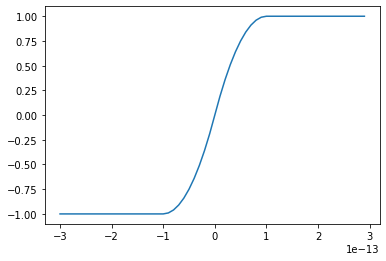

In [163]:
#First derivative of rho around 0
t = [0.1*i*gamma for i in range(-30,30)]
plt.plot(t,[drho(x) for x in t])

# Proximal operators
The objective is to find the point minimizing $f_u(x) = F(x)+1/2||x-u||^2$ for a given u and for $F=\tau F1,\tau F2,\tau G$ where $\tau$ is a given constant.
## Proximal operator of F2
We want to minimize $f_u(x) = \tau\alpha (p)J(|x|)+\frac{1}{2}||x-u||^2$. As explained in the paper, given the definition of J, we can compute the solution component by component, but the paper expresses $x_i$ in terms of $u_i$ with a constant C that we need to compute. We have in 1D $f_u'(x) = \tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$. Since $\rho '(x)$ depends on if $|x|<\gamma$ or not, we need to separate these two cases:
### |x|>$\gamma$
In this case, $\rho '(|x|)=1$, so we simply have $(1+\frac{\tau\alpha(p)}{|x|})x=u\Rightarrow x=(|u|-\tau\alpha(p))\frac{u}{|u|}$. Since we supposed $|x|<\gamma$ beforehand, this will be true when $|u|>\tau\alpha(p)+\gamma$.
### |x|$\leq\gamma$
From what we just saw, this is equivalent to $|u|\leq\tau\alpha(p)+\gamma$. This case is a bit more complicated, since now $\rho '(|x|)=-\frac{|x|^2}{\gamma^2}+2\frac{|x|}{\gamma}$ and taking the norm on both sides of $\tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$ gives us:
$$-\frac{\tau\alpha(p)}{\gamma^2}|x|^2+(1+\frac{2\tau\alpha(p)}{\gamma})|x|-|u|=0\\
\Rightarrow |x| = \gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1\pm\sqrt{\Delta})\\
with\ \Delta=1+\frac{4\tau\alpha(p)}{\gamma^2}(\gamma+\tau\alpha(p)-|u|)$$
But since we want $|x|<\gamma$, the only acceptable solution is $x=\left(\gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1-\sqrt{\Delta})\right)\frac{u}{|u|}$. Since $|u|\leq\tau\alpha(p)+\gamma$, we see that $\Delta>1$, so the condition $|x|\leq\gamma$ is verified.

## Proximal dual operators
We use the Moreau identity to compute the proximal dual operators:
$$prox_{\gamma\phi ^*}(x) = x-\gamma prox_{\phi/\gamma}(\frac{x}{\gamma})$$

In [164]:
#Prox_tauG
def prox_B(u,c):
    return np.asarray([[x/(0.5+np.sqrt(0.25-3*zeta*c*min(0,x)))for x in u[i]]for i in range(len(u))])
def prox_G(u,c):
    return prox_B(u/(1+epsilon),c/(1+epsilon))

In [165]:
y1 = prox_G(u0_mat,2)
y2 = y1+np.asarray([[np.random.normal(0,1e-7)for i in range(n2)]for j in range(n1)])

r1 = 2*g(y1)+0.5*np.linalg.norm(u0_mat-y1)**2
r2 = 2*g(y2)+0.5*np.linalg.norm(u0_mat-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):"
                  ,np.abs(r1)/np.abs(r2))

Distance between the two points: 5.125174546891143e-05
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.9952329684601299


In [166]:
#Prox_tau/F2
def prox_F2(u,c):
    n = len(u)
    v = np.asarray([0+0j for i in range(n)])
    for i in range(n):
        mod_u = np.abs(u[i])
        if mod_u>c*pn1+gamma:
            v[i] = (mod_u-c*pn1)*u[i]/np.abs(u[i])
        else:
            delta = 1+4*c*pn1/(gamma**2)*(gamma+c*pn1-mod_u)
            v[i] = (gamma+gamma**2/(2*c*pn1)*(1-np.sqrt(delta)))*u[i]/np.abs(u[i])
    return v
def prox_F2_dual(u,c):
    return u-c*prox_F2(u/c,1/c)

In [167]:
c=2
x = np.asarray([1,2,3,4])
y1 = prox_F2(x,c)
y2 = y1+np.asarray([np.random.normal(0,1e-5)for i in range(4)])

r1 = c*f2(y1)+0.5*np.linalg.norm(x-y1)**2
r2 = c*f2(y2)+0.5*np.linalg.norm(x-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):",r1/r2)

Distance between the two points: 2.65048663290064e-05
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.9999912828942908


In [168]:
#prox_tauF1
def prox_F1(u,c):
    im = (fourier_op.op(u)+c*p*p*y)/(np.ones(y.shape)+c*p*p)
    return gridded_inverse_fourier_transform_nd(kspace_loc, im,
                                                 tuple(grid2D), 'linear')
def prox_F1_dual(u,c):
    return u-c*prox_F1(u/c,1/c)

In [169]:
c=2
y1 = prox_F1(u0_mat,c)
y2 = y1+np.asarray([[np.random.normal(0,1e-6)for i in range(n2)]for j in range(n1)])

r1 = c*f1(y1)+0.5*np.linalg.norm(u0_mat-y1)**2
r2 = c*f1(y2)+0.5*np.linalg.norm(u0_mat-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):",r1/r2)

Distance between the two points: 0.0005122025038168591
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 1.0019019846427675


# Implementation of the PDHG algorithm

In [170]:
#constants
L=1
eta = max(np.amax(p)**2,pn1*j(np.reshape(u0_mat,(n1*n2,1))))
mu = 2*np.sqrt(epsilon/(1+L*L)/eta)
tau = mu/2/epsilon
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 10
tol = 1e-3

In [171]:
def step(uk,vk,wk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    wk1 = prox_F2_dual(wk+sigma*linear_op.op(uk_bar),sigma)
    uk1 = prox_G(uk-tau*R(vk1)-tau*linear_op.adj_op(wk1),tau)
    uk_bar1 = theta*(uk1-uk)
    
    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [172]:
#initialisation
n_iter = 0
uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
vk = np.copy(uk)
wk = linear_op.op(u0_mat)
uk_bar = np.copy(uk)
norm = 2*tol
print("Base ssim:",ssim(uk,u0_mat))
while n_iter<maxit and norm>tol:
    uk,vk,wk,uk_bar,norm = step(uk,vk,wk,uk_bar)
    n_iter += 1
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

Base ssim: 0.6462845584106313
Final ssim after  10  iterations: 0.9767154015039287


In [173]:
#Final image
image_rec0 = pysap.Image(data=np.abs(uk))
image_rec0.show()

## Convergence

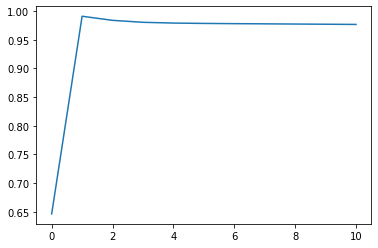

In [174]:
t = [i for i in range(11)]
uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
vk = np.copy(uk)
wk = linear_op.op(u0_mat)
uk_bar = np.copy(uk)
ssims = [ssim(uk,u0)]
for i in range(10):
    uk,vk,wk,uk_bar,norm = step(uk,vk,wk,uk_bar)
    ssims.append(ssim(uk,u0))
plt.plot(t,ssims)

# Comparison to other optimization algorithms

In [175]:
max_iter = 200
x_final, costs, metrics = sparse_rec_fista(
    gradient_op=gradient_op,
    linear_op=linear_op,
    prox_op=prox_op,
    cost_op=cost_op,
    lambda_init=1.0,
    max_nb_of_iter=max_iter,
    atol=1e-4,
    verbose=1)
image_rec = pysap.Image(data=np.abs(x_final))
fista_ssim = ssim(x_final,u0)

N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2e-06
 - lipschitz constant:  570.4519942001267
 - data:  (512, 512)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fd0941e4390> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (262144,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:43 Time:  0:00:43


 - final iteration number:  200
 - final log10 cost value:  -5.25661369178952
 - converged:  True
Done.
Execution time:  307.8325360000001  seconds
----------------------------------------


0.8446063182574627